# Discovering a parsimonious neural network - particle under an external linear potential#

<i>Saaketh Desai</i>, and <i>Alejandro Strachan</i>, School of Materials Engineering, Purdue University <br>

This notebook describes the procedure to train a parsimonious neural network for the simple case of a harmonic oscillator. In this case, we will learn how a simple neural network can learn an accurate integration scheme, serving as a useful baseline. The outline of this notebook is:

1. Generate a training and a testing dataset
2. Create the neural network
3. Train the network
4. Evaluate the network
5. Writing down the network as an equation

In [1]:
import tensorflow as tf
import keras
from keras import backend as K
from keras import initializers
from keras.layers import Dense, Input, Activation
from keras.models import Sequential, Model, load_model
from keras.layers.merge import add, concatenate

from sklearn.model_selection import train_test_split

import numpy as np
import sys
import os
import random

import matplotlib.pyplot as plt

Using TensorFlow backend.


As always, we define some globally relevant parameters

In [2]:
origin = 0
w = 1
mass = 3
A = 1
init_pos = origin
init_vel = A*w
timestep = 0.01

## Step 1: Generate training and testing datasets ##

We will generate the data from the analytical solution of the harmonic oscillator, where we know that the position and velocity of the oscillator can be computed exactly as follows:
<br> $x(t) = Asin(\omega t)$ </br>
<br> $v(t) = A\omega cos(\omega t)$ </br>
<br> We then use the scikit-learn <i> train_test_split() </i> function to split the datasets into training and testing sets

In [3]:
train_time = 25 #np.ceil(2*np.pi / w)
eval_time = 25

In [4]:
inputs = np.array([[A*np.sin(w*t), A*w*np.cos(w*t)]  for t in np.arange(0, train_time, timestep)])
outputs = inputs[1:]
inputs = inputs[:-1]
print ("Inputs = ", inputs.shape)
print ("Outputs = ", outputs.shape)

#split into train and validation sets
train_inputs, val_inputs, train_outputs, val_outputs = train_test_split(inputs[:,0:2], outputs[:,0:2], test_size=0.2, random_state=0)
print (train_inputs.shape, train_outputs.shape)
print (val_inputs.shape, val_outputs.shape)


#generate testing data
test_inputs = np.array([[2*A*np.sin(w*t), 2*A*w*np.cos(w*t)]  for t in np.arange(0, eval_time, timestep)])
test_outputs = test_inputs[1:]
test_inputs = test_inputs[:-1]

Inputs =  (2499, 2)
Outputs =  (2499, 2)
(1999, 2) (1999, 2)
(500, 2) (500, 2)


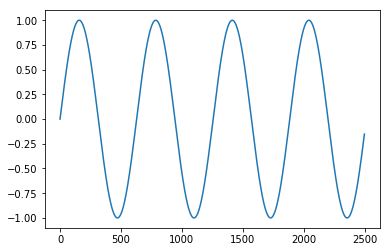

In [5]:
plt.plot(inputs[:, 0])

## Step 2: Create the neural network

For a simple spring mass system where the force is a linear function of the position, we do not need a pre-trained force block to discover the Verlet integration scheme. A network with 2 inputs and 2 outputs and linear activations discovers all the physics of the system

In [6]:
def create_model():
    
    input_position = Input(shape=(1,))
    input_velocity = Input(shape=(1,))
    input_layer = concatenate([input_position, input_velocity])
    initializer = keras.initializers.RandomUniform(minval=-1, maxval=1, seed=123456)
    output_position = Dense(1, activation='linear', use_bias = False, name="op", 
                         trainable = True, kernel_initializer = initializer) (input_layer)
    output_velocity = Dense(1, activation='linear', use_bias = False, name="ov", 
                         trainable = True, kernel_initializer = initializer) (input_layer)
    
    model = Model(inputs=[input_position, input_velocity], outputs=[output_position, output_velocity])
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    model.summary()
    
    return model

In [7]:
model = create_model()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
op (Dense)                      (None

## Step 3: Train the network

We now define the training protocol for the network

In [8]:
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + '\t' + str(logs.get('loss')) + '\r') # Updates current Epoch Number
        

def train(model, train_inputs, train_outputs, val_inputs, val_outputs, verbose = True):
    
    mae_es= keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-20, 
                                          verbose=1, mode='auto', restore_best_weights=True)    
    EPOCHS = 100 # Number of EPOCHS
    history = model.fit([train_inputs[:,0], train_inputs[:,1]], [train_outputs[:,0], train_outputs[:,1]], epochs=EPOCHS, verbose = False, 
                        validation_data = ([val_inputs[:,0], val_inputs[:,1]], [val_outputs[:,0], val_outputs[:,1]]), callbacks=[PrintEpNum(), mae_es])
    
    if verbose:
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Sq Error')
        plt.plot(history.epoch, np.array(history.history['loss']),label='Regular model') 
        plt.legend()
        plt.show()
        
        print(list(np.array(history.history['loss']))[-10:])
        print("Trained Weights:", model.get_weights())
        
    return

Instructions for updating:
Use tf.cast instead.


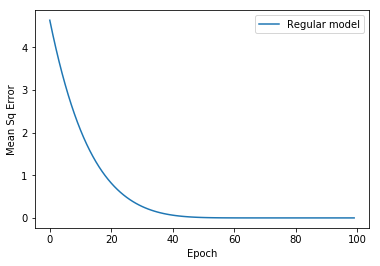

[6.732869184778079e-11, 2.3149893511727814e-11, 1.485811889877075e-11, 1.4857612247570125e-11, 1.485764065746365e-11, 1.4507368629868634e-11, 1.3716253500019493e-11, 1.2960135078591214e-11, 1.1168246297091285e-11, 1.0431516234314044e-11]
Trained Weights: [array([[0.9999467 ],
       [0.00999984]], dtype=float32), array([[-0.00999982],
       [ 0.9999469 ]], dtype=float32)]


In [9]:
train(model, train_inputs, train_outputs, val_inputs, val_outputs, verbose = True)

## Step 4: Evaluate the network

We will first evaluate the network by computing the mean squared error on the training, validation and testing sets.

In [10]:
mse_train = model.evaluate([train_inputs[:,0], train_inputs[:,1]], [train_outputs[:,0], train_outputs[:,1]])
mse_val = model.evaluate([val_inputs[:,0], val_inputs[:,1]], [val_outputs[:,0], val_outputs[:,1]])
mse_test = model.evaluate([test_inputs[:,0], test_inputs[:,1]], [test_outputs[:,0], test_outputs[:,1]])

print ("MSE on training set: ", mse_train)
print ("MSE on validation set: ", mse_val)
print ("MSE on test set: ", mse_test)

2499/2499 [==============================] - 0s 16us/step
MSE on training set:  [1.0236684699525632e-11, 5.393581697509805e-12, 4.843103036944602e-12]
MSE on validation set:  [1.0254435758860759e-11, 5.586089622117152e-12, 4.6683463136854006e-12]
MSE on test set:  [4.096094558502447e-11, 2.1728394795785204e-11, 1.923255085483806e-11]


We will now visually inspect the trajectories obtained by this network and plot it against the analytical solution

In [12]:
def run_NN(init_pos, init_vel, timestep, total_time, model):
    
    time_array = np.arange(0, total_time, timestep)
    pos = np.zeros(len(time_array))
    vel = np.zeros(len(time_array))
    pos[0] = init_pos
    vel[0] = init_vel
    
    eval_inputs = [np.array([init_pos]), np.array([init_vel])]
    
    for frame in range(len((time_array))-1):
        p = model.predict(eval_inputs)
        pos[frame+1] = p[0][0][0]
        vel[frame+1] = p[1][0][0]
        eval_inputs = [ np.array( [ p[0][0][0] ] ), np.array( [ p[1][0][0] ] ) ]
        
    return pos, vel, time_array

In [13]:
def plot_trajectory(step, time, data_slice, y1, y2):
    
    x_axis = np.arange(0, time, step)[:data_slice]
    fig, axes = plt.subplots(figsize=(24,12))
    plt.plot(x_axis, y1[:data_slice], 'r-', label='Training Data')
    plt.plot(x_axis, y2[:data_slice], 'b-', label='NN')
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Position", fontsize=20)
    axes.set_xticklabels([round(x,3) for x in axes.get_xticks()], fontsize=20)
    axes.set_yticklabels([round(y,3) for y in axes.get_yticks()], fontsize=20)
    plt.legend(bbox_to_anchor=(1.05, 0.5), fontsize =20)
    plt.grid()
    plt.show()
    
    return

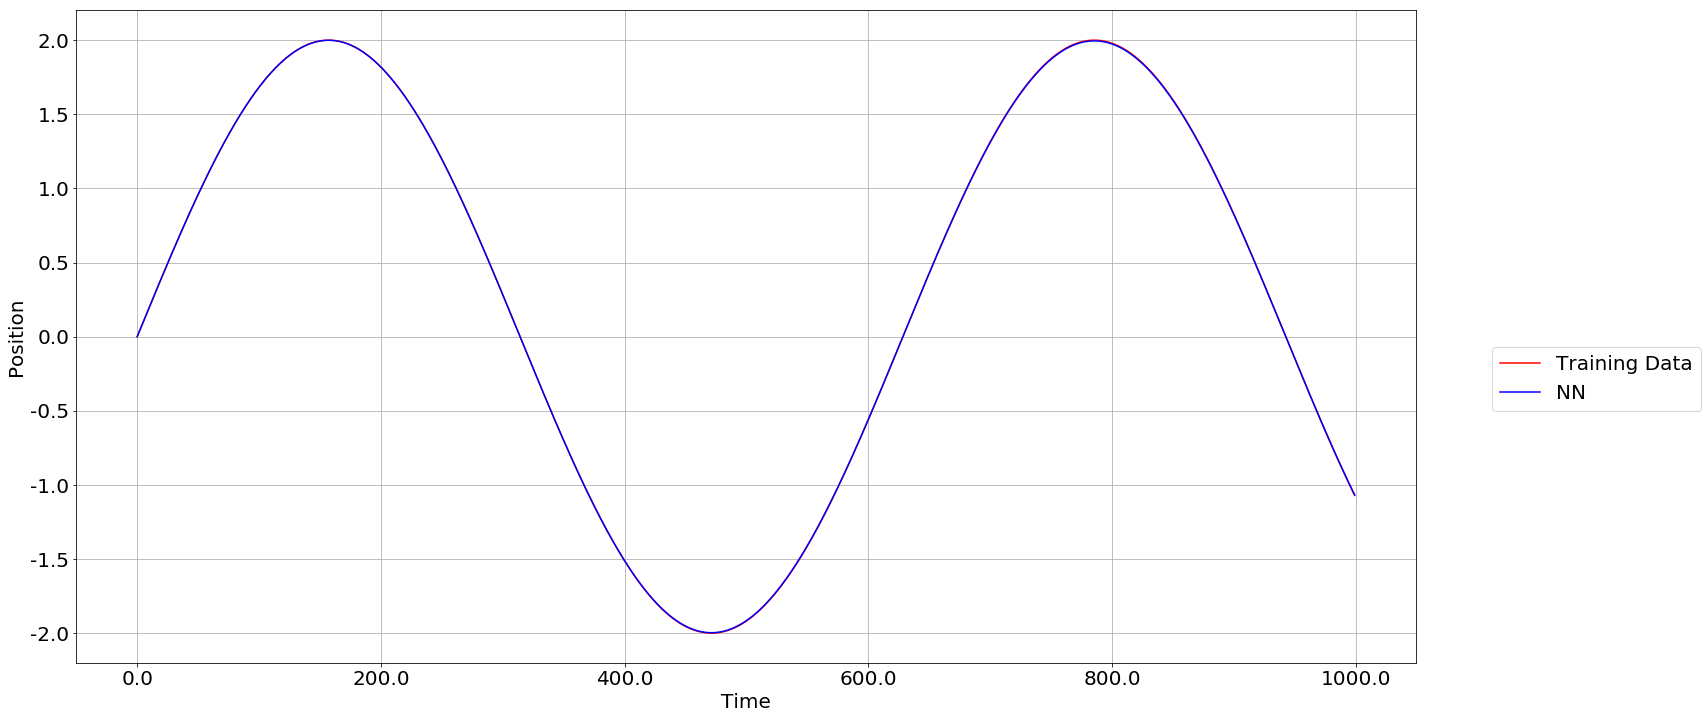

In [14]:
pos, vel, time_array = run_NN(test_inputs[0][0], test_inputs[0][1], 1, 1000, model)
plot_trajectory(1, 1000, 1000, test_inputs[:,0], pos)

Lastly, we will inspect the reversibility of the network by running a forward integration for a 1000 steps, followed by reversing the velocity and running another 1000 steps of integration.

Mean error in pos:  0.0013385193897411227
Std error in pos:  0.004973240181352025
Mean error in vel:  0.00024767379369586707
Std error in vel:  0.005228238239956234


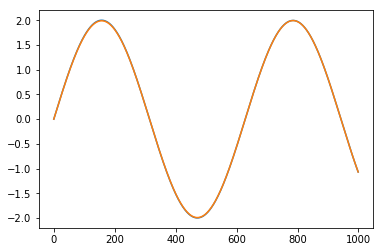

In [15]:
#run forward (starting from arbitrary position and velocity within training set) for 10000 steps
pos_f, vel_f, time_array_f = run_NN(test_inputs[0][0], test_inputs[0][1], 1, 1000, model)
#run backward for 10000 steps
pos_b, vel_b, time_array_b = run_NN(pos_f[-1], -vel_f[-1], 1, 1000, model)

error_x = pos_f - pos_b[::-1]
print ("Mean error in pos: ", np.mean(error_x))
print ("Std error in pos: ", np.std(error_x))

error_v = vel_f - -vel_b[::-1]
print ("Mean error in vel: ", np.mean(error_v))
print ("Std error in vel: ", np.std(error_v))

plt.plot(pos_f)
plt.plot(pos_b[::-1])

## Step 5: Writing the network as an equation ##
Here, we will first begin by writing the equation for the position Verlet integration scheme, following which we will compare the weights with the weights learned by our network.
We find that the network learns weights corresponding to the Verlet integration scheme

In [25]:
weight_array = model.get_weights()
x_coeff_x = weight_array[0][0][0]
x_coeff_v = weight_array[0][1][0]
v_coeff_x = weight_array[1][0][0]
v_coeff_v = weight_array[1][1][0]
print ("Learned weights:")
learned_weights = [x_coeff_x, x_coeff_v, v_coeff_x, v_coeff_v]
print (learned_weights)

x_coeff_x = 1 - w**2*timestep**2/2
x_coeff_v = timestep - w**2*timestep**3/4
v_coeff_x = -w**2*timestep
v_coeff_v = 1 - w**2*timestep**2/2
print ("True weights:")
true_weights = [x_coeff_x, x_coeff_v, v_coeff_x, v_coeff_v]
print (true_weights)

print ("Ratio:")
ratio = [i/j for i, j in zip(learned_weights, true_weights)]
print (ratio)

Learned weights:
[0.9999467, 0.009999843, -0.009999824, 0.9999469]
True weights:
[0.99995, 0.00999975, -0.01, 0.99995]
Ratio:
[0.9999967132832349, 1.0000093316622962, 0.999982375651598, 0.9999968921061104]


In our case, the final discovered PNN model can be written as:
<br> $ x(t+\Delta t) = (1 - \frac{\omega ^2 \Delta t ^2}{2}) x(t) + (\Delta t - \frac{\omega ^2 \Delta t ^3}{4}) v(t) $ </br>
<br> $ v(t+\Delta t) = 0.99998 (- \omega ^2 \Delta t) x(t) + (1 - \frac{\omega ^2 \Delta t ^2}{2}) v(t) $ </br>